In [225]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import time
import tensorflow as tf
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

In [226]:
def get_data():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    return X, y

In [227]:
def specificity(y_true, y_score):
    threshold = 0.5
    y_pred = tf.cast(tf.greater_equal(y_score, threshold), tf.float32)

    true_negatives = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))
    num_true_negatives = tf.reduce_sum(tf.cast(true_negatives, tf.float32))

    negatives = tf.equal(y_true, 0)
    num_negatives = tf.reduce_sum(tf.cast(negatives, tf.float32))

    specificity = num_true_negatives / (num_negatives + tf.keras.backend.epsilon())

    return specificity

In [228]:
def compile_fit(net, x, y, first_layer, optimizer, learning_rate):
    tf.keras.utils.set_random_seed(5)
    layers = net
    model = Sequential()

    for idx, layer in enumerate(layers):
        if idx == 0:
            model.add(Dense(layer, activation='elu', input_dim=first_layer))
        elif idx == len(layers) - 1:
            model.add(Dense(layer, activation='sigmoid'))
        else:
            model.add(Dense(layer, activation='elu'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rate),
                  metrics=['Recall', 'AUC', specificity])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    mark1 = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=False)
    mark2 = time.time()

    time_elapsed = mark2 - mark1

    return model, history, time_elapsed

In [229]:
def plot_metrics(figure, history, title):
    axe_loss = figure.add_subplot(2, 2, 1)
    axe_loss.plot(
        history['loss'], linestyle='dotted', color="#003B80", label=f'loss entrenamiento {history["loss"][-1]:.2f}'
    )
    axe_loss.plot(history['val_loss'], color="#003B80", label=f'loss validacion {history["val_loss"][-1]:.2f}')

    axe_loss.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_loss.xaxis.set_major_locator(MultipleLocator(3))

    axe_loss.set_ylabel('Perdida', color='#003B80', fontsize=13)
    axe_loss.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_loss.set_ylim(ymin=0, ymax=1.1)

    axe_loss.set_title('loss')
    axe_loss.set_facecolor("#E3F7FA")
    axe_loss.grid(visible=True, which='major', axis='both', color='white')
    axe_loss.set_axisbelow(True)
    axe_loss.legend()

    axe_recall = figure.add_subplot(2, 2, 2)
    axe_recall.plot(
        history['recall'], linestyle='dotted', color="#003B80",
        label=f'recall entrenamiento {history["recall"][-1]:.2f}'
    )
    axe_recall.plot(history['val_recall'], color="#003B80", label=f'recall validacion {history["val_recall"][-1]:.2f}')

    axe_recall.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_recall.xaxis.set_major_locator(MultipleLocator(3))

    axe_recall.set_ylabel('Recall', color='#003B80', fontsize=13)
    axe_recall.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_recall.set_ylim(ymin=0, ymax=1.1)

    axe_recall.set_title('recall')
    axe_recall.set_facecolor("#E3F7FA")
    axe_recall.grid(visible=True, which='major', axis='both', color='white')
    axe_recall.set_axisbelow(True)
    axe_recall.legend()

    axe_specificity = figure.add_subplot(2, 2, 3)
    axe_specificity.plot(
        history['specificity'], linestyle='dotted', color="#003B80",
        label=f'specificity entrenamiento {history["specificity"][-1]:.2f}'
    )
    axe_specificity.plot(history['val_specificity'], color="#003B80",
                         label=f'specificity validacion {history["val_specificity"][-1]:.2f}')

    axe_specificity.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_specificity.xaxis.set_major_locator(MultipleLocator(3))

    axe_specificity.set_ylabel('Specificity', color='#003B80', fontsize=13)
    axe_specificity.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_specificity.set_ylim(ymin=0, ymax=1.1)

    axe_specificity.set_title('specificity')
    axe_specificity.set_facecolor("#E3F7FA")
    axe_specificity.grid(visible=True, which='major', axis='both', color='white')
    axe_specificity.set_axisbelow(True)
    axe_specificity.legend()

    axe_auc = figure.add_subplot(2, 2, 4)
    axe_auc.plot(
        history['auc'], linestyle='dotted', color="#003B80",
        label=f'AUC entrenamiento {history["auc"][-1]:.2f}'
    )
    axe_auc.plot(history['val_auc'], color="#003B80", label=f'AUC validacion {history["val_auc"][-1]:.2f}')

    axe_auc.set_xlabel('Nº de época', color='#003B80', fontsize=13)
    axe_auc.xaxis.set_major_locator(MultipleLocator(3))

    axe_auc.set_ylabel('AUC', color='#003B80', fontsize=13)
    axe_auc.yaxis.set_major_locator(MultipleLocator(0.1))
    axe_auc.set_ylim(ymin=0, ymax=1.1)

    axe_auc.set_title('AUC')
    axe_auc.set_facecolor("#E3F7FA")
    axe_auc.grid(visible=True, which='major', axis='both', color='white')
    axe_auc.set_axisbelow(True)
    axe_auc.legend()

In [230]:
X, y = get_data()

In [231]:
model_trained, history, time_elapsed = compile_fit([30, 64, 32, 16, 8, 1], X, y, 30, tf.keras.optimizers.Adam, 0.0001)

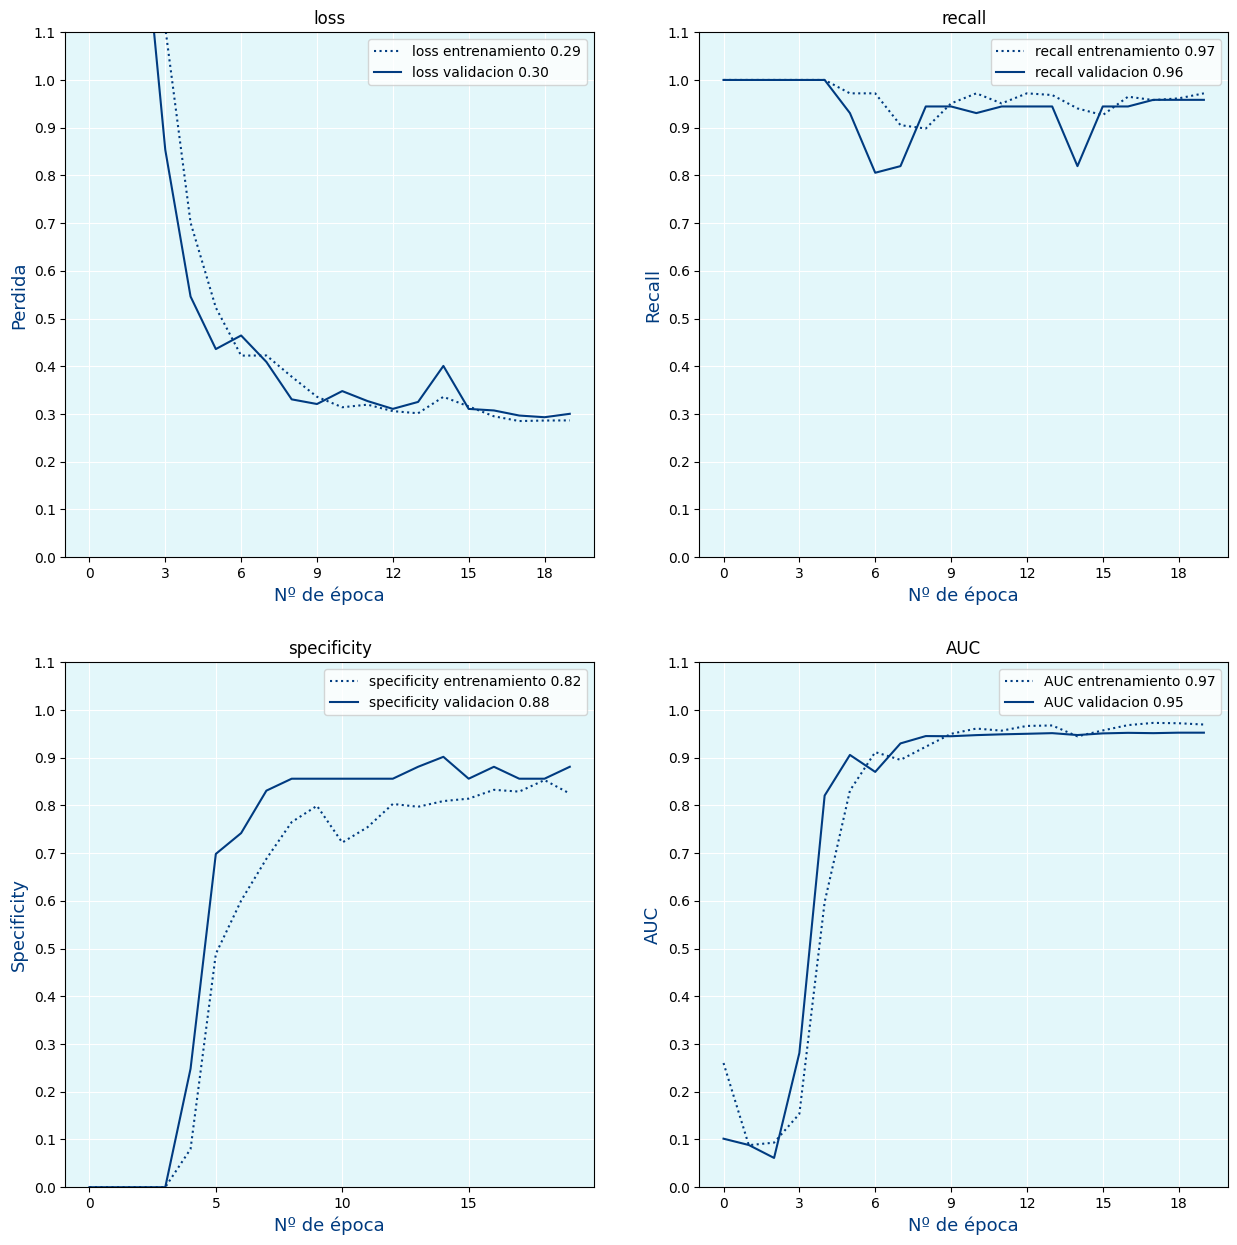

In [232]:
figure = plt.figure(figsize=(15, 15))

plot_metrics(figure, history.history, 'Red Neuronal')

In [233]:
model_trained.save('model.h5')

C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
